In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports loaded!")

✅ Imports loaded!


In [ ]:
# Load Data
train_df = pd.read_csv('../data/raw/task_dataset-training_dataset.csv')
val_df = pd.read_csv('../data/raw/task_dataset-validation_dataset.csv')

X_train = train_df['property_address']
y_train = train_df['categories']
X_val = val_df['property_address']
y_val = val_df['categories']

print(f"Training: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Categories: {sorted(y_train.unique())}")

Training: 8936 samples
Validation: 2681 samples
Categories: ['commercial unit', 'flat', 'houseorplot', 'landparcel', 'others']


In [ ]:
# Helper Function for Evaluation
def evaluate_model(name, y_true, y_pred):
    """Comprehensive model evaluation"""
    print(f"\n{'='*60}")
    print(f"MODEL: {name}")
    print(f"{'='*60}")
    
    # Classification report
    print("\nCLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred))
    
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\nKEY METRICS:")
    print(f"  Accuracy:    {acc:.4f}")
    print(f"  Macro F1:    {macro_f1:.4f}")
    print(f"  Weighted F1: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y_true.unique()),
                yticklabels=sorted(y_true.unique()))
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'../results/confusion_matrix_{name.replace(" ", "_").lower()}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'Model': name,
        'Accuracy': acc,
        'Macro F1': macro_f1,
        'Weighted F1': weighted_f1
    }

In [ ]:
# Feature Extraction - TF-IDF
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),  # unigrams, bigrams, trigrams
    min_df=2,
    max_df=0.95,
    strip_accents='unicode',
    lowercase=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print(f"✅ TF-IDF shape: {X_train_tfidf.shape}")
print(f"   Features: {len(tfidf.get_feature_names_out())}")

Creating TF-IDF features...
✅ TF-IDF shape: (8936, 5000)
   Features: 5000


Training Baseline: Logistic Regression...

MODEL: Logistic Regression

CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

commercial unit       0.92      0.92      0.92       290
           flat       0.96      0.89      0.92       970
    houseorplot       0.90      0.85      0.87       802
     landparcel       0.77      0.84      0.80       260
         others       0.67      0.84      0.75       359

       accuracy                           0.87      2681
      macro avg       0.84      0.87      0.85      2681
   weighted avg       0.88      0.87      0.87      2681


KEY METRICS:
  Accuracy:    0.8668
  Macro F1:    0.8514
  Weighted F1: 0.8699


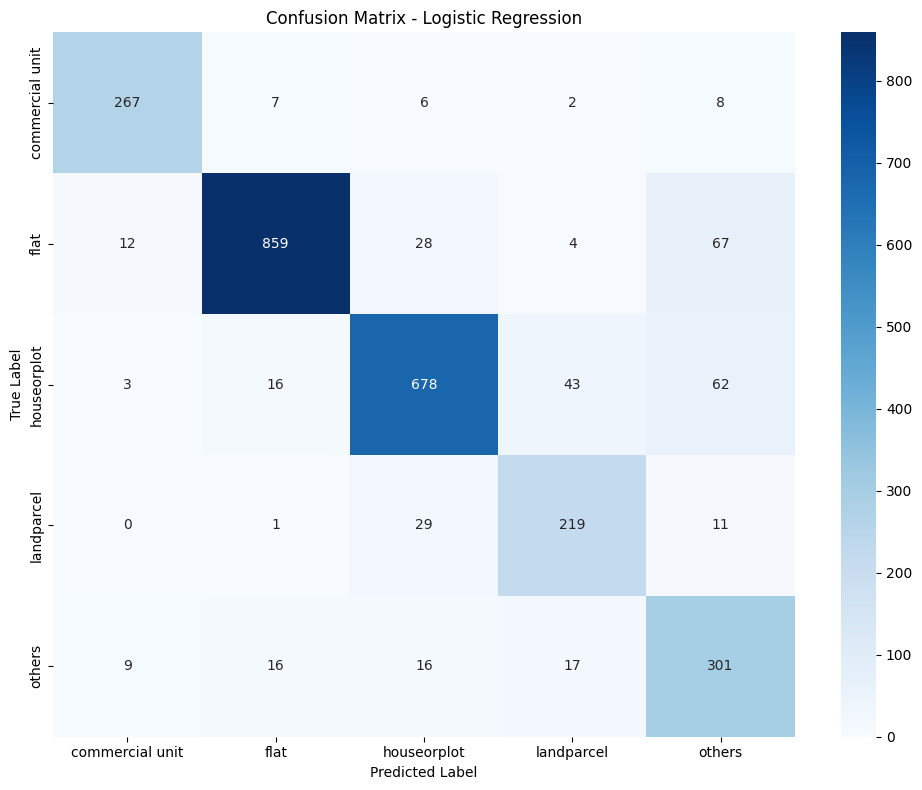

In [ ]:
# Baseline Model - Logistic Regression
print("Training Baseline: Logistic Regression...")

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    solver='saga',
    n_jobs=-1
)

lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_val_tfidf)

results = []
results.append(evaluate_model('Logistic Regression', y_val, y_pred_lr))

Training Random Forest...

MODEL: Random Forest

CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

commercial unit       0.96      0.85      0.90       290
           flat       0.98      0.85      0.91       970
    houseorplot       0.92      0.79      0.85       802
     landparcel       0.81      0.78      0.80       260
         others       0.53      0.94      0.68       359

       accuracy                           0.84      2681
      macro avg       0.84      0.84      0.83      2681
   weighted avg       0.88      0.84      0.85      2681


KEY METRICS:
  Accuracy:    0.8381
  Macro F1:    0.8270
  Weighted F1: 0.8488


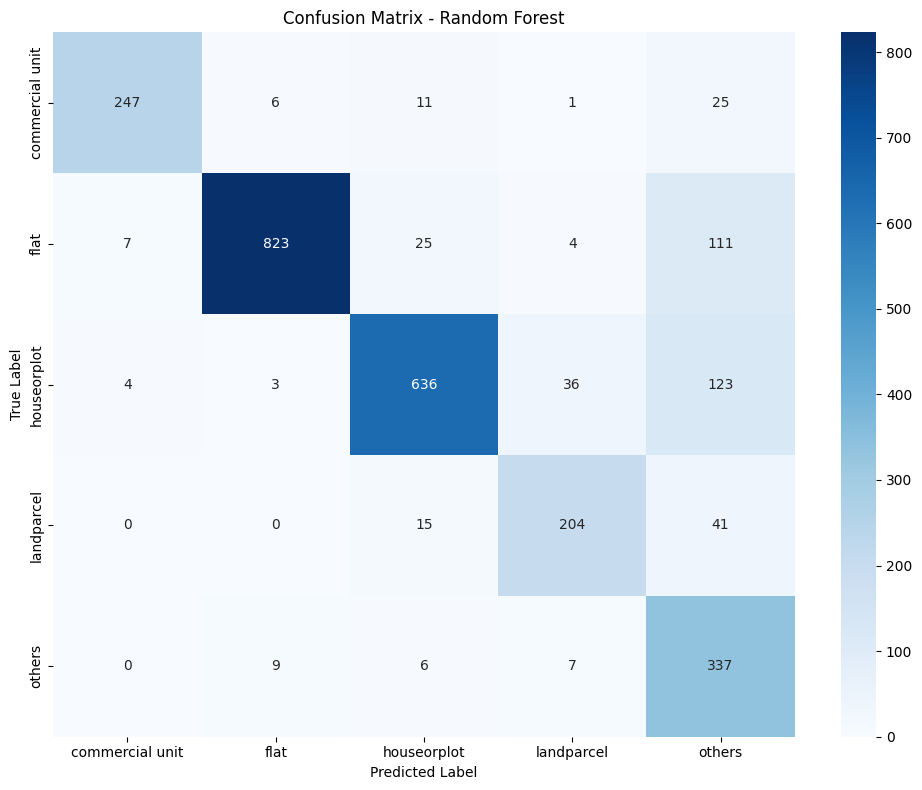

In [ ]:
# Random Forest
print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_val_tfidf)

results.append(evaluate_model('Random Forest', y_val, y_pred_rf))

Training XGBoost...

MODEL: XGBoost

CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

commercial unit       0.97      0.90      0.94       290
           flat       0.96      0.93      0.94       970
    houseorplot       0.88      0.90      0.89       802
     landparcel       0.82      0.83      0.83       260
         others       0.78      0.85      0.81       359

       accuracy                           0.90      2681
      macro avg       0.88      0.88      0.88      2681
   weighted avg       0.90      0.90      0.90      2681


KEY METRICS:
  Accuracy:    0.8978
  Macro F1:    0.8823
  Weighted F1: 0.8988


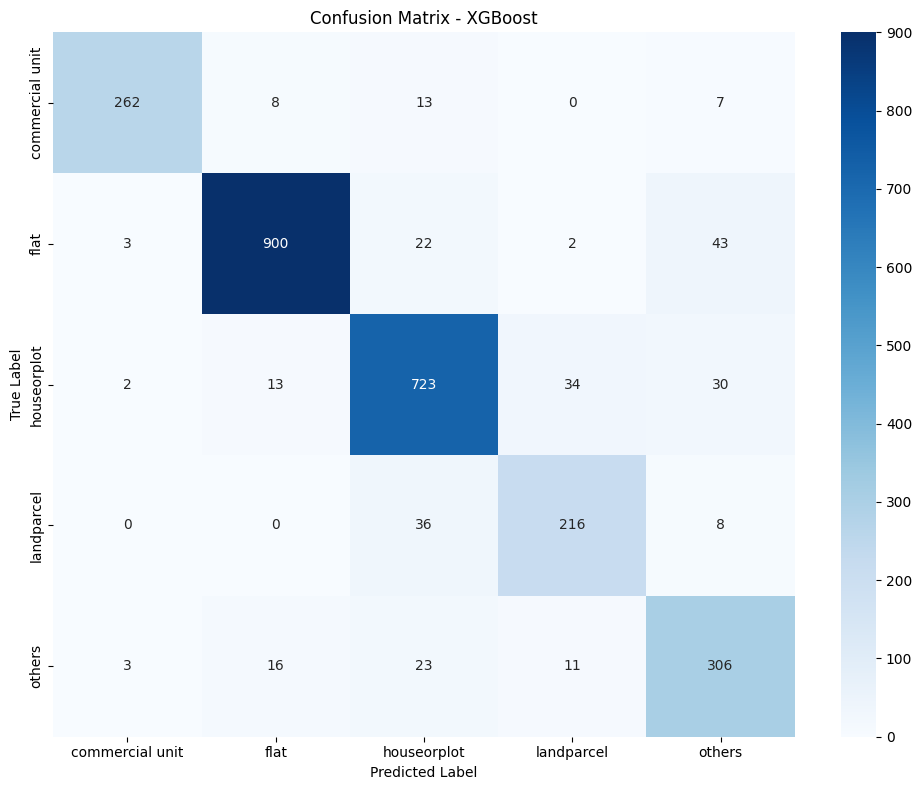

In [ ]:
# XGBoost
print("Training XGBoost...")

# Encode labels for XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1
)

xgb_model.fit(X_train_tfidf, y_train_encoded)
y_pred_xgb_encoded = xgb_model.predict(X_val_tfidf)
y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)

results.append(evaluate_model('XGBoost', y_val, y_pred_xgb))

Training LightGBM...

MODEL: LightGBM

CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

commercial unit       0.96      0.94      0.95       290
           flat       0.96      0.93      0.94       970
    houseorplot       0.89      0.89      0.89       802
     landparcel       0.80      0.82      0.81       260
         others       0.78      0.83      0.80       359

       accuracy                           0.90      2681
      macro avg       0.88      0.88      0.88      2681
   weighted avg       0.90      0.90      0.90      2681


KEY METRICS:
  Accuracy:    0.8967
  Macro F1:    0.8805
  Weighted F1: 0.8975


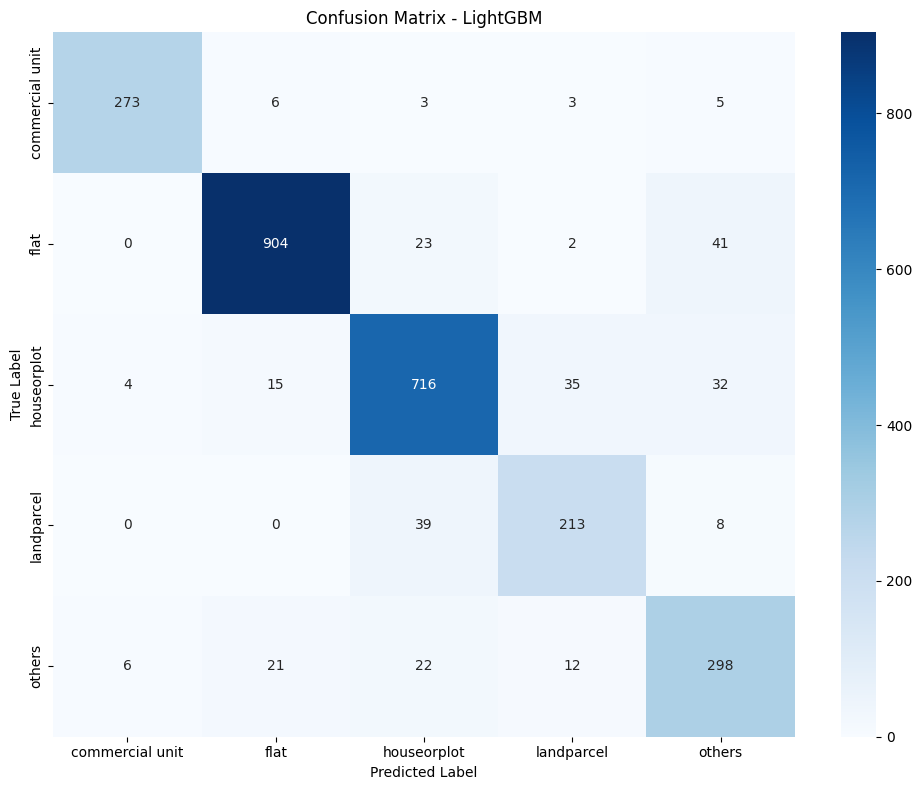

In [ ]:
# LightGBM
print("Training LightGBM...")

lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgbm_model.fit(X_train_tfidf, y_train_encoded)
y_pred_lgbm_encoded = lgbm_model.predict(X_val_tfidf)
y_pred_lgbm = le.inverse_transform(y_pred_lgbm_encoded)

results.append(evaluate_model('LightGBM', y_val, y_pred_lgbm))


MODEL COMPARISON
              Model  Accuracy  Macro F1  Weighted F1
            XGBoost  0.897799  0.882300     0.898833
           LightGBM  0.896680  0.880461     0.897485
Logistic Regression  0.866841  0.851364     0.869888
      Random Forest  0.838120  0.826954     0.848766


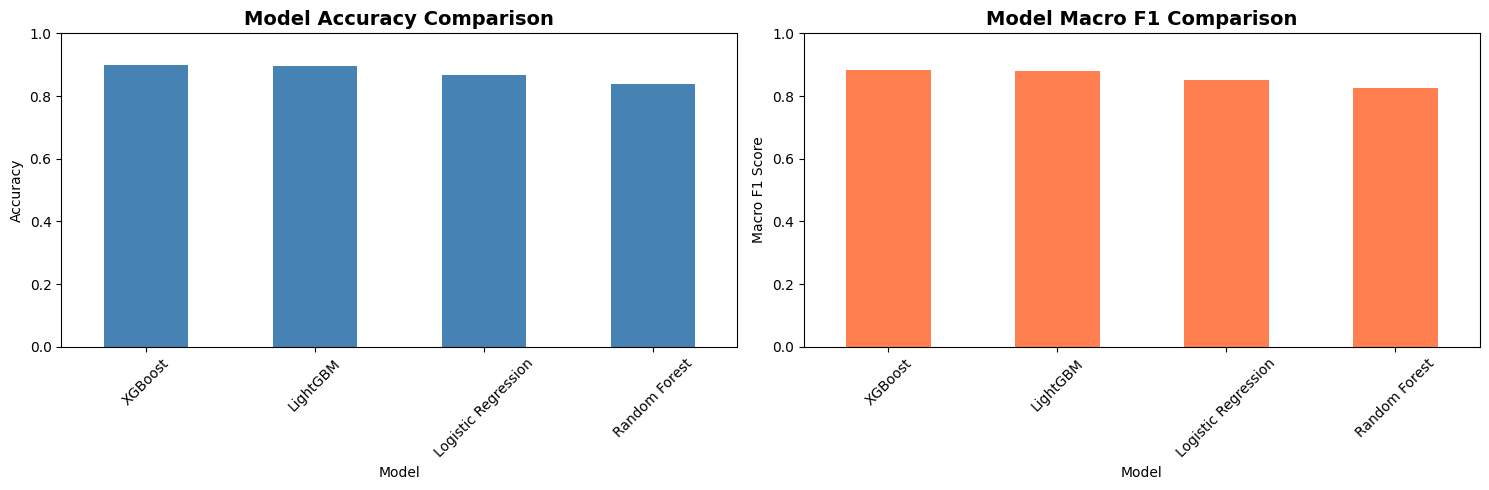


✅ Results saved to results/model_comparison.csv


In [12]:
# Model Comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Macro F1', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('../results/model_comparison.csv', index=False)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

results_df.plot(x='Model', y='Accuracy', kind='bar', ax=ax[0], color='steelblue', legend=False)
ax[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Accuracy')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylim([0, 1])

results_df.plot(x='Model', y='Macro F1', kind='bar', ax=ax[1], color='coral', legend=False)
ax[1].set_title('Model Macro F1 Comparison', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Macro F1 Score')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Results saved to results/model_comparison.csv")

In [14]:
# Select Best Model and Save
best_model_name = results_df.iloc[0]['Model']
print(f"\n Best Model: {best_model_name}")
print(f"   Macro F1: {results_df.iloc[0]['Macro F1']:.4f}")

# Determine which model to save
if best_model_name == 'XGBoost':
    best_model = xgb_model
elif best_model_name == 'LightGBM':
    best_model = lgbm_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
else:
    best_model = lr_model

# Save artifacts
print("\nSaving model artifacts...")
joblib.dump(best_model, '../best_model/classifier.pkl')
joblib.dump(tfidf, '../best_model/vectorizer.pkl')
joblib.dump(le, '../best_model/label_encoder.pkl')

print("✅ Model saved to best_model/ folder!")
print("\nSaved files:")
print("  - classifier.pkl")
print("  - vectorizer.pkl")
print("  - label_encoder.pkl")


 Best Model: XGBoost
   Macro F1: 0.8823

Saving model artifacts...
✅ Model saved to best_model/ folder!

Saved files:
  - classifier.pkl
  - vectorizer.pkl
  - label_encoder.pkl
